# Week 3 - Attitude Control of States and Rates

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"../../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_shadow
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


In [3]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next


In [4]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

In [5]:
def mrp_compose(s1, s2, mode="add"):
    """
    mrp_compose(s1, s2, mode)

    Q = mrp_compose(s1, s2, mode) provides the MRP vector corresponding to:

        mode = "add" :
            successive rotations s1 followed by s2

        mode = "sub" :
            relative rotation from s2 to s1

    This is a unified implementation of addMRP and subMRP.
    """

    # Ensure column-like vectors (but works with 1D arrays)
    s1 = np.asarray(s1, dtype=float).reshape(3,)
    s2 = np.asarray(s2, dtype=float).reshape(3,)

    s1_sq = np.dot(s1, s1)
    s2_sq = np.dot(s2, s2)
    s1_dot_s2 = np.dot(s1, s2)
    s1_cross_s2 = np.cross(s1, s2)

    if mode == "add":
        # --- MRP addition (successive rotations) ---
        q = ((1 - s1_sq) * s2 + (1 - s2_sq) * s1 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq - 2 * s1_dot_s2)

    elif mode == "sub":
        # --- MRP subtraction (relative attitude) ---
        q = ((1 - s2_sq) * s1 - (1 - s1_sq) * s2 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq + 2 * s1_dot_s2)

    else:
        raise ValueError("mode must be 'add' or 'sub'")

    return mrp_shadow(q)


## CC1, Q4

In [6]:
def cc1_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC1 general attitude tracking controller.

    This implements the globally asymptotically stabilizing control law
    used in both Q4 and Q5.

    Q4 regulator case:
        sigma_RN = 0
        omega_RN_R = 0
        omega_dot_RN_R = 0

    Q5 tracking case:
        sigma_RN, omega_RN_R, omega_dot_RN_R are time varying.

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference
    ---------
    ref["sigma_RN"]       : MRPs of reference R relative to N
    ref["omega_RN_R"]     : angular rate of R relative to N expressed in R
    ref["omega_dot_RN_R"] : angular acceleration of R relative to N expressed in R

    Context
    -------
    ctx["sc"]["I"]   : inertia matrix in body frame B
    ctx["sc"]["L_B"] : external disturbance torque in B, default zero
    ctx["ctl"]["K"]  : attitude gain
    ctx["ctl"]["P"]  : rate gain

    Returns
    -------
    u_B : control torque expressed in body frame B
    """

    # Unpack state
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # Unpack reference with defaults for regulator case
    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    # Unpack context
    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(ctx["sc"].get("L_B", np.zeros(3)), dtype=float).reshape(3,)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])

    # Attitude error sigma_BR
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Relative kinematics in body frame
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    # Feedforward term
    ff = I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))

    # Gyroscopic compensation
    gyro = np.cross(omega_BN_B, I @ omega_BN_B)

    # Control torque
    u_B = -K * sigma_BR - P * omega_BR_B + ff + gyro - L_B

    return u_B

In [7]:
def cc_xdot_mrp(
    t: float,
    x: np.ndarray,
    u_B: np.ndarray,
    ctx: dict,
) -> np.ndarray:
    """
    Rigid-body MRP attitude dynamics (plant model only).

    This function defines the continuous-time plant dynamics:

        x_dot = f(t, x, u)

    where the state is:
        x = [ sigma_BN (3), omega_BN_B (3) ]

    and the control input is:
        u_B = body control torque expressed in frame B.

    No controller logic is included here. This function represents
    the physical spacecraft rotational dynamics only.

    Parameters
    ----------
    t : float
        Current simulation time [s]. (Not explicitly used here but
        included for compatibility with generic integrators.)

    x : np.ndarray, shape (6,)
        State vector:
            x[0:3] = sigma_BN     (MRPs of body B relative to inertial N)
            x[3:6] = omega_BN_B   (angular rate of B wrt N, expressed in B) [rad/s]

    u_B : np.ndarray, shape (3,)
        Control torque applied in body frame B [N*m].

    ctx : dict
        Context dictionary containing spacecraft parameters under
        the "sc" namespace:
            ctx["sc"]["I"]   : inertia matrix in body frame B (3x3)
            ctx["sc"]["L_B"] : external disturbance torque applied
                            to the plant (3,) [N*m] (default zero)

    Returns
    -------
    xdot : np.ndarray, shape (6,)
        Time derivative of the state vector:
            xdot[0:3] = sigma_dot   (MRP kinematics)
            xdot[3:6] = omega_dot_B (rigid-body rotational dynamics)
    """
    x = np.asarray(x, dtype=float).reshape(-1,)
    if x.size != 6:
        raise ValueError(f"cc_xdot expects state length 6, got {x.size}")

    # ---- unpack state ----
    sigma_BN = ak.MRP_shadow(x[0:3])
    omega_BN_B = x[3:6]

    # ---- input torque ----
    u_B = np.asarray(u_B, dtype=float).reshape(3,)

    # ---- plant parameters (spacecraft truth only) ----
    sc = ctx["sc"]
    I = np.asarray(sc["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(sc.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    # ---- rigid-body rotational dynamics ----
    # I * omega_dot = u + L - omega x (I omega)
    omega_dot_B = np.linalg.solve(I, u_B + L_B - np.cross(omega_BN_B, I @ omega_BN_B))

    # ---- MRP kinematics ----
    # sigma_dot = 0.25 * B(sigma) * omega
    sigma_dot = 0.25 * (ak.Bmat_MRP(sigma_BN) @ omega_BN_B)
    
    # Pack state derivative
    xdot = np.hstack((sigma_dot, omega_dot_B))
    
    return xdot


In [8]:
def simulate_CC(
    controller=cc1_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params: dict | None = None,
    controller_params: dict | None = None,
    simulation_config: dict | None = None,
    reference_config: dict | None = None,
    grading_config: dict | None = None,
):
    """
    RK4 simulator harness for Coursera attitude concept checks.

    This simulator integrates the 6-state rigid-body attitude dynamics:
        x = [sigma_BN (MRP), omega_BN_B]

    using a fixed-step RK4 integrator.

    ZOH semantics (grading-critical):
    - The controller is evaluated once per outer step at time t_k.
    - The resulting u_B is held constant during the RK4 sub-stages for that step.
    - This is implemented by passing u_B into the plant as a constant input for the RK4 step.

    Parameters
    ----------
    controller : callable
        Control law with signature:
            u_B = controller(t, state, ref_k, ctx)

        where:
            state : dict with keys {"sigma_BN", "omega_BN_B"}
            ref_k : dict with keys {"sigma_RN", "omega_RN_R", "omega_dot_RN_R"}
            ctx   : dict with namespaces:
                    ctx["sc"]  spacecraft parameters (truth)
                    ctx["ctl"] controller parameters + memory

    plant : callable
        Plant state derivative with signature:
            xdot = plant(t, x, u_B, ctx)

        Note:
        - plant is purely physics. It does not call the controller.
        - plant should read only spacecraft truth parameters from ctx["sc"].

    spacecraft_params : dict
        Spacecraft physical parameters (truth).
        Typical keys:
            "I"   (3x3): inertia matrix in B
            "L_B" (3,): external disturbance torque applied to the plant

    controller_params : dict
        Controller parameters and controller memory.
        Typical keys:
            "K", "P", "Ki"
            "modelL_B" (3,)  (optional model estimate; not used by all controllers)
            "integral_sigma_BR" (3,) (controller memory)
            "omega_BR0_B" (3,)       (controller memory / initialization)

    simulation_config : dict
        Simulation setup:
            {"t0": float, "tf": float, "dt": float,
             "sigma0": (3,), "omega0_deg": (3,), "eta0": (3,) optional}

    reference_config : dict
        Reference generation configuration:
            {"mode": "tracking"|"regulator", "f": float}

        For tracking mode, this function generates sigma_RN(t) as in the concept checks.

    grading_config : dict
        Coursera helper for printing a norm at a chosen time:
            {"time_s": float, "quantity": "sigma_BR"|"sigma_BN"}

    Returns
    -------
    results : dict
        Time histories and key logged quantities.
    """
    # ---- Default dictionaries ----
    if spacecraft_params is None:
        spacecraft_params = {}
    if controller_params is None:
        controller_params = {}
    if simulation_config is None:
        simulation_config = {}
    if reference_config is None:
        reference_config = {}
    if grading_config is None:
        grading_config = {}

    spacecraft_params = dict(spacecraft_params)
    controller_params = dict(controller_params)
    simulation_config = dict(simulation_config)
    reference_config = dict(reference_config)
    grading_config = dict(grading_config)

    # ---- Time setup ----
    t0 = float(simulation_config.get("t0", 0.0))
    tf = float(simulation_config.get("tf", 120.0))
    dt = float(simulation_config.get("dt", 0.01))

    t_hist = np.arange(t0, tf + dt, dt)
    N = t_hist.size

    # ---- Spacecraft parameters ----
    if "I" not in spacecraft_params:
        spacecraft_params["I"] = np.diag([100.0, 75.0, 80.0])
    spacecraft_params["I"] = np.asarray(spacecraft_params["I"], dtype=float).reshape(3, 3)

    spacecraft_params.setdefault("L_B", np.zeros(3))
    spacecraft_params["L_B"] = np.asarray(spacecraft_params["L_B"], dtype=float).reshape(3,)

    # ---- Controller parameters ----
    controller_params.setdefault("K", 5.0)
    controller_params.setdefault("P", 10.0)
    controller_params.setdefault("Ki", 0.0)
    controller_params.setdefault("modelL_B", np.zeros(3))
    controller_params["modelL_B"] = np.asarray(controller_params["modelL_B"], dtype=float).reshape(3,)

    # ---- Initial conditions ----
    sigma0 = np.asarray(simulation_config.get("sigma0", [0.1, 0.2, -0.1]), dtype=float).reshape(3,)
    omega0_deg = np.asarray(simulation_config.get("omega0_deg", [30.0, 10.0, -20.0]), dtype=float).reshape(3,)
    omega0 = np.deg2rad(omega0_deg)

    x = np.hstack((sigma0, omega0))
    x[0:3] = mrp_shadow(x[0:3])

    # ---- Integral memory ----
    eta0 = simulation_config.get("eta0", None)
    if eta0 is None:
        controller_params.setdefault("integral_sigma_BR", np.zeros(3))
    else:
        controller_params["integral_sigma_BR"] = np.asarray(eta0, dtype=float).reshape(3,)

    # ---- Reference generation ----
    ref_mode = str(reference_config.get("mode", "tracking")).lower()
    f = float(reference_config.get("f", 0.05))

    sigma_RN_hist = np.zeros((N, 3))
    omega_RN_R_hist = np.zeros((N, 3))
    omega_dot_RN_R_hist = np.zeros((N, 3))

    if ref_mode == "tracking":
        for k, tt in enumerate(t_hist):
            st = np.sin(f * tt)
            ct = np.cos(f * tt)

            sigma_RN = np.array([0.2 * st, 0.3 * ct, -0.3 * st])
            sigma_RN_dot = np.array([0.2 * f * ct, -0.3 * f * st, -0.3 * f * ct])

            sigma_RN_hist[k] = sigma_RN
            omega_RN_R_hist[k] = 4.0 * ak.BInvmat_MRP(sigma_RN) @ sigma_RN_dot

        omega_dot_RN_R_hist[:] = np.gradient(omega_RN_R_hist, t_hist, axis=0)

    elif ref_mode == "regulator":
        # Leave reference histories as zeros
        pass
    else:
        raise ValueError("reference_config['mode'] must be 'tracking' or 'regulator'")

    # ---- Grading setup ----
    report_time_s = float(grading_config.get("time_s", 40.0))
    report_quantity = str(grading_config.get("quantity", "sigma_BR"))

    # ---- Initialize omega_BR0_B if needed ----
    if "omega_BR0_B" not in controller_params:
        sigma_BN0 = x[0:3]
        omega_BN_B0 = x[3:6]

        sigma_RN0 = sigma_RN_hist[0]
        omega_RN_R0 = omega_RN_R_hist[0]

        C_BN0 = ak.MRP_to_DCM(sigma_BN0)
        C_RN0 = ak.MRP_to_DCM(sigma_RN0)
        C_BR0 = C_BN0 @ C_RN0.T

        omega_RN_B0 = C_BR0 @ omega_RN_R0
        controller_params["omega_BR0_B"] = omega_BN_B0 - omega_RN_B0

    # ---- Storage ----
    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))

    sigma_BN_hist = np.zeros((N, 3))
    omega_BN_B_hist = np.zeros((N, 3))

    sigma_BR_hist = np.zeros((N, 3))
    omega_BR_hist = np.zeros((N, 3))
    sigma_norm_hist = np.zeros(N)
    z_hist = np.zeros((N, 3))

    # ---- Namespaced context ----
    ctx = {
        "sc": spacecraft_params,
        "ctl": controller_params,
    }

    # ---- Simulation loop ----
    for k, tt in enumerate(t_hist):
        # Progress reporting every 30 seconds
        if k == 0:
            next_report_t = 30.0
        if tt >= next_report_t:
            print(f"simulate_CC: simulated up to t = {next_report_t:.0f} s")
            next_report_t += 30.0

        sigma_BN = x[0:3]
        omega_BN_B = x[3:6]

        sigma_BN_hist[k] = sigma_BN
        omega_BN_B_hist[k] = omega_BN_B

        state = {
            "sigma_BN": sigma_BN,
            "omega_BN_B": omega_BN_B,
        }

        ref_k = {
            "sigma_RN": sigma_RN_hist[k],
            "omega_RN_R": omega_RN_R_hist[k],
            "omega_dot_RN_R": omega_dot_RN_R_hist[k],
        }

        # ---- Compute tracking errors (in B) ----
        C_BN = ak.MRP_to_DCM(sigma_BN)
        C_RN = ak.MRP_to_DCM(ref_k["sigma_RN"])
        C_BR = C_BN @ C_RN.T

        sigma_BR = ak.DCM_to_MRP(C_BR)
        omega_BR_B = omega_BN_B - C_BR @ ref_k["omega_RN_R"]

        # ---- Update integral state (single owner: ctx["ctl"]) ----
        ctx["ctl"]["integral_sigma_BR"] += dt * sigma_BR

        # ---- Log z quantity ----
        eta = ctx["ctl"]["integral_sigma_BR"]
        omega_BR0_B = ctx["ctl"]["omega_BR0_B"]
        z = ctx["ctl"]["K"] * eta + ctx["sc"]["I"] @ (omega_BR_B - omega_BR0_B)
        z_hist[k] = z

        # ---- Store error histories ----
        sigma_BR_hist[k] = sigma_BR
        omega_BR_hist[k] = omega_BR_B
        sigma_norm_hist[k] = (
            np.linalg.norm(sigma_BN)
            if report_quantity == "sigma_BN"
            else np.linalg.norm(sigma_BR)
        )

        # ---- Sample controller once per step (ZOH) ----
        u_B = controller(tt, state, ref_k, ctx)
        u_hist[k] = u_B

        x_hist[k] = x

        # ---- Integrate plant with held control ----
        if k < N - 1:
            x_next = rk4_step(
                plant,
                tt,
                x,
                dt,
                u_B,
                ctx,
            )
            x_next[0:3] = mrp_shadow(x_next[0:3])
            x = x_next

    # ---- Grading output ----
    idx = np.argmin(np.abs(t_hist - report_time_s))
    label = "sigma_BN" if report_quantity == "sigma_BN" else "sigma_BR"
    print(f"CC: norm({label}) at t={t_hist[idx]:.3f} s = {sigma_norm_hist[idx]:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "sigma_BN": sigma_BN_hist,
        "omega_BN_B": omega_BN_B_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR_B": omega_BR_hist,
        "z": z_hist,
        "u": u_hist,
        "sigma_norm": sigma_norm_hist,
        "params": {
            "spacecraft_params": spacecraft_params,
            "controller_params": controller_params,
        },
        "meta": {
            "simulation_config": {"t0": t0, "tf": tf, "dt": dt},
            "reference_config": {"mode": ref_mode, "f": f},
            "grading_config": {"time_s": report_time_s, "quantity": report_quantity},
        },
    }
    return results

In [9]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "regulator",  # "tracking" or "regulator"
    "f": 0.0,             # only used for tracking mode
}

grading_config = {
    "time_s": 30.0,
    "quantity": "sigma_BN",  # "sigma_BN" or "sigma_BR"
}


cc1q4_sim_result = simulate_CC(
    controller=cc1_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc1q4_sim_result

simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
CC: norm(sigma_BN) at t=30.000 s = 0.194829038966894


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317421e-01,
          5.23025123e-01,  1.74166267e-01, -3.48567474e-01],
        [ 1.02058631e-01,  2.00886939e-01, -1.02634238e-01,
          5.22451530e-01,  1.73799801e-01, -3.48068897e-01],
        ...,
        [-1.02464209e-03,  3.64315683e-05,  5.42430746e-04,
         -3.73760529e-04,  4.62514354e-05, -8.79605486e-05],
        [-1.02557553e-03,  3.65456256e-05,  5.42210391e-04,
         -3.72874447e-04,  4.61654791e-05, -8.81896170e-05],
        [-1.02650675e-03,  3.66594693e-05,  5.41989464e-04,
         -3.71988785e-04,  4.60795614e-05, -8.84182614e-05]]),
 'sigma_BN': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317421e-01],
        [ 1.02058631

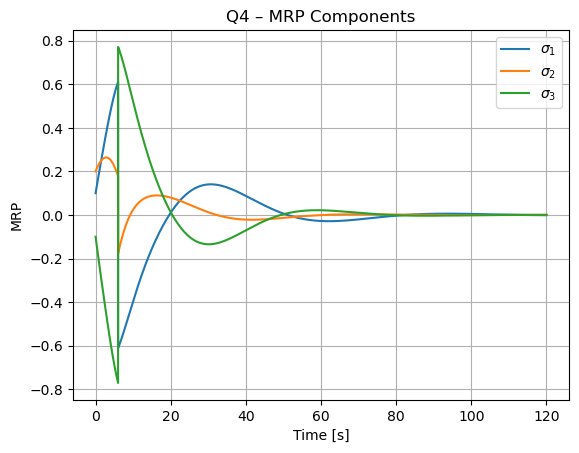

In [10]:
t = cc1q4_sim_result['t']
x = cc1q4_sim_result['x']
u = cc1q4_sim_result['u']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q4 – MRP Components")
plt.legend()
plt.show()

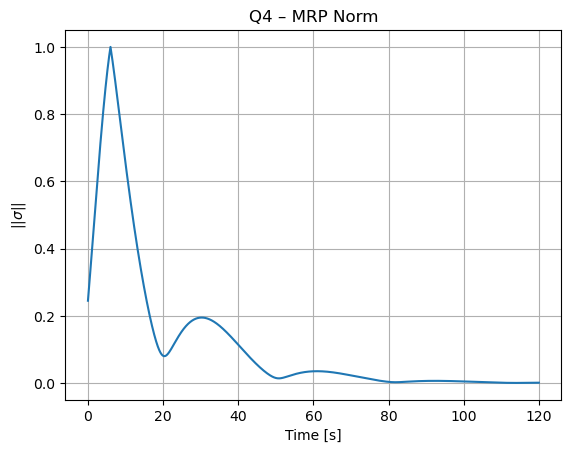

In [11]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma||$")
plt.title("Q4 – MRP Norm")
plt.show()


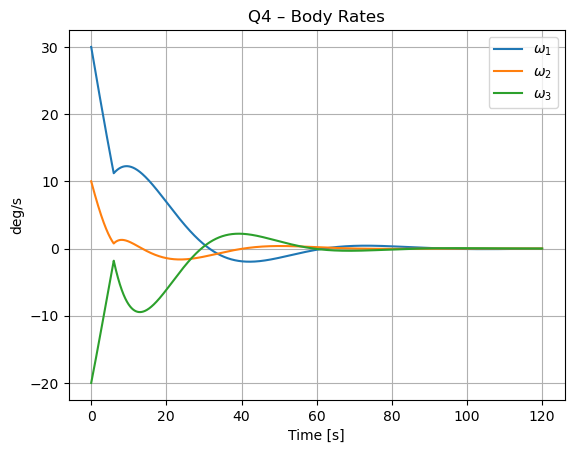

In [12]:
plt.figure()
plt.plot(t, omega_deg[:, 0], label=r'$\omega_1$')
plt.plot(t, omega_deg[:, 1], label=r'$\omega_2$')
plt.plot(t, omega_deg[:, 2], label=r'$\omega_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q4 – Body Rates")
plt.legend()
plt.show()

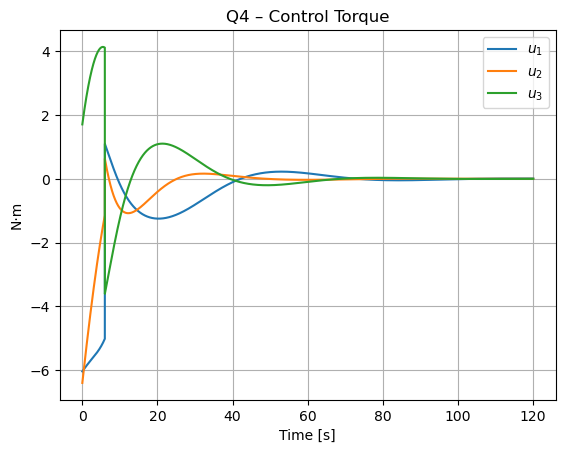

In [13]:
plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("N·m")
plt.title("Q4 – Control Torque")
plt.legend()
plt.show()


## CC1, Q5

In [14]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}


reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 40.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc1q5_sim_result = simulate_CC(
    controller=cc1_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)

cc1q5_sim_result

simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
CC: norm(sigma_BR) at t=40.000 s = 0.158862416280276


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317911,  0.17427388,
         -0.348504  ],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275912,  0.17401595,
         -0.34794191],
        ...,
        [-0.05647211,  0.2880658 ,  0.08413538,  0.06063146,  0.01183167,
         -0.02395752],
        [-0.05637357,  0.2881084 ,  0.08398954,  0.06063558,  0.01181131,
         -0.02396383],
        [-0.05627501,  0.28815093,  0.08384368,  0.0606397 ,  0.01179094,
         -0.02397014]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102978,  0.20044435, -0.1013174 ],
        [ 0.10205962,  0.20088729, -0.10263417],
        ...,
        [-0.05647211,  0.2880658 ,  0.08413538],
        [-0.05637357,  0.2881084 ,  0.08398954],
        [-0.05627501,  0.288

In [15]:
t = cc1q5_sim_result["t"]
x = cc1q5_sim_result["x"]
sigma_BR = cc1q5_sim_result["sigma_BR"]
omega_BR = cc1q5_sim_result["omega_BR_B"]

sigma_BN = x[:, 0:3]
omega_BN = x[:, 3:6]
omega_BN_deg = np.rad2deg(omega_BN)

omega_BR_deg = np.rad2deg(omega_BR)

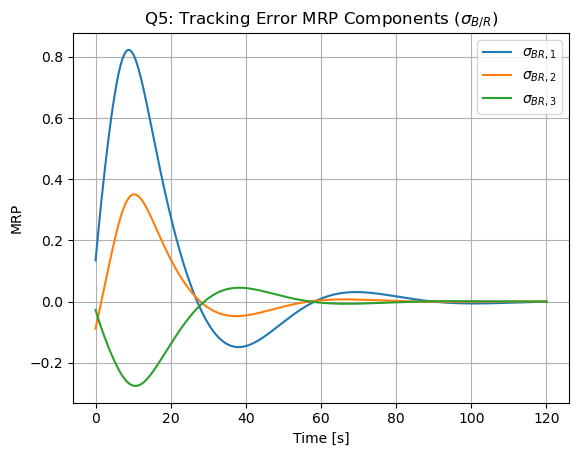

In [16]:
plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_{BR,1}$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_{BR,2}$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Tracking Error MRP Components ($\\sigma_{B/R}$)")
plt.legend()
plt.show()


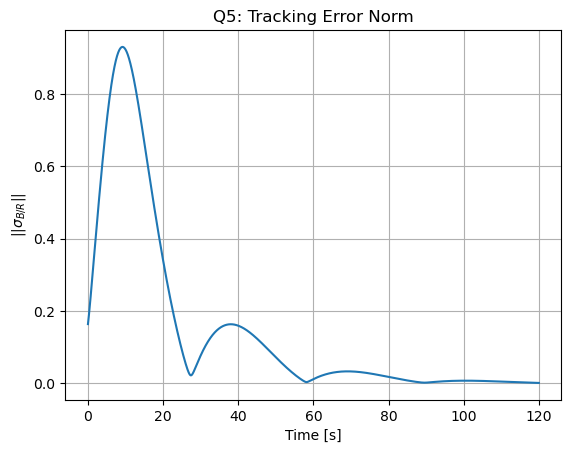

In [17]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma_BR, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma_{B/R}||$")
plt.title("Q5: Tracking Error Norm")
plt.show()


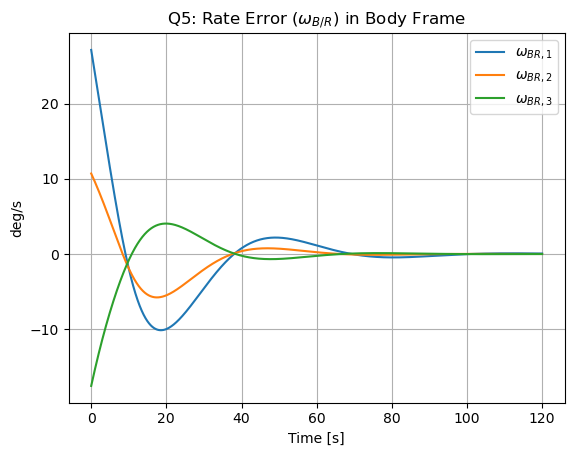

In [18]:
plt.figure()
plt.plot(t, omega_BR_deg[:, 0], label=r'$\omega_{BR,1}$')
plt.plot(t, omega_BR_deg[:, 1], label=r'$\omega_{BR,2}$')
plt.plot(t, omega_BR_deg[:, 2], label=r'$\omega_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Rate Error ($\\omega_{B/R}$) in Body Frame")
plt.legend()
plt.show()


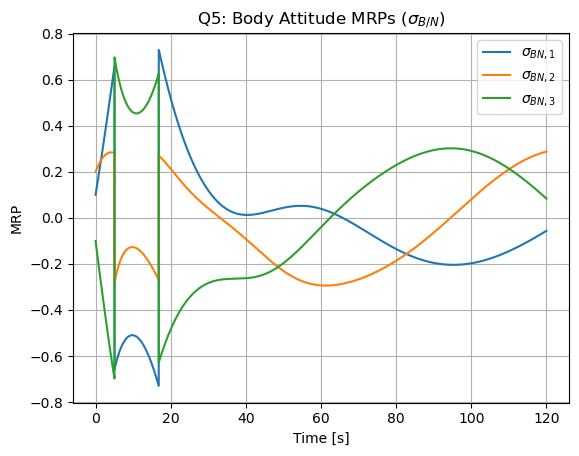

In [19]:
plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_{BN,1}$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_{BN,2}$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Body Attitude MRPs ($\\sigma_{B/N}$)")
plt.legend()
plt.show()


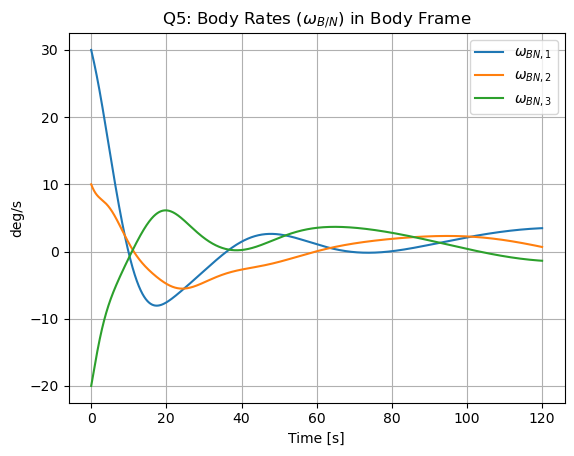

In [20]:
plt.figure()
plt.plot(t, omega_BN_deg[:, 0], label=r'$\omega_{BN,1}$')
plt.plot(t, omega_BN_deg[:, 1], label=r'$\omega_{BN,2}$')
plt.plot(t, omega_BN_deg[:, 2], label=r'$\omega_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Body Rates ($\\omega_{B/N}$) in Body Frame")
plt.legend()
plt.show()


## CC2, Q5

In [21]:
def cc2_q5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q5 attitude tracking controller (PD on attitude and rate error).

    Control law:
        u_B = -K * sigma_BR - P * omega_BR_B

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference
    ---------
    ref["sigma_RN"]   : MRPs of reference R relative to N
    ref["omega_RN_R"] : angular rate of R relative to N expressed in R

    Context
    -------
    ctx["ctl"]["K"] : attitude gain
    ctx["ctl"]["P"] : rate gain

    Returns
    -------
    u_B : (3,) control torque expressed in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Rate error
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = -K * sigma_BR - P * omega_BR_B
    return u_B

In [22]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 20.0,
    "quantity": "sigma_BR",
}

cc2q5_sim_results = simulate_CC(
    controller=cc2_q5_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc2q5_sim_results


simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
CC: norm(sigma_BR) at t=20.000 s = 0.377523227271322


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102989,  0.20044504, -0.1013171 ,  0.52308775,  0.17482938,
         -0.34837962],
        [ 0.10206009,  0.20089004, -0.10263294,  0.52257667,  0.17512354,
         -0.34769359],
        ...,
        [-0.06727215,  0.31419886,  0.1249365 ,  0.06804622,  0.01167109,
         -0.02216157],
        [-0.06716311,  0.3142538 ,  0.12477454,  0.06805335,  0.01165287,
         -0.02217127],
        [-0.06705406,  0.31430867,  0.12461254,  0.06806047,  0.01163464,
         -0.02218096]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102989,  0.20044504, -0.1013171 ],
        [ 0.10206009,  0.20089004, -0.10263294],
        ...,
        [-0.06727215,  0.31419886,  0.1249365 ],
        [-0.06716311,  0.3142538 ,  0.12477454],
        [-0.06705406,  0.314

## CC2, Q6

In [23]:
def cc2_q6_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q6 attitude tracking controller (PD + feedforward + gyro compensation).

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
              + cross(omega_BN_B, I*omega_BN_B)

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference
    ---------
    ref["sigma_RN"]       : MRPs of reference R relative to N
    ref["omega_RN_R"]     : angular rate of R relative to N expressed in R
    ref["omega_dot_RN_R"] : angular acceleration of R relative to N expressed in R

    Context
    -------
    ctx["sc"]["I"]  : inertia matrix in body frame B
    ctx["ctl"]["K"] : attitude gain
    ctx["ctl"]["P"] : rate gain

    Notes
    -----
    This controller does not subtract a disturbance torque term.
    Any external torque, if present, should be modeled in the plant
    using ctx["sc"]["L_B"].
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate and accel into B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
    )
    return u_B


In [24]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 80.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc2q6_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc2q6_sim_results

simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
CC: norm(sigma_BR) at t=80.000 s = 0.134400970122661


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102984,  0.20044428, -0.10131741,  0.52322911,  0.17423389,
         -0.34847902],
        [ 0.10205986,  0.20088701, -0.10263419,  0.52285904,  0.17393598,
         -0.34789199],
        ...,
        [ 0.06772573,  0.24359263,  0.06553989,  0.05364965, -0.01105673,
         -0.03860922],
        [ 0.06780677,  0.24359556,  0.06538034,  0.05364852, -0.01107864,
         -0.03860715],
        [ 0.0678878 ,  0.24359841,  0.06522079,  0.05364738, -0.01110053,
         -0.03860507]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102984,  0.20044428, -0.10131741],
        [ 0.10205986,  0.20088701, -0.10263419],
        ...,
        [ 0.06772573,  0.24359263,  0.06553989],
        [ 0.06780677,  0.24359556,  0.06538034],
        [ 0.0678878 ,  0.243

## CC2, Q7

In [25]:
def cc2_q7_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q7 attitude tracking controller (PD + feedforward + gyro compensation + disturbance cancellation).

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
              + cross(omega_BN_B, I*omega_BN_B)
              - L_B

    State
    -----
    state["sigma_BN"]   : MRPs of body B relative to inertial N
    state["omega_BN_B"] : angular rate of B relative to N expressed in B

    Reference
    ---------
    ref["sigma_RN"]       : MRPs of reference R relative to N
    ref["omega_RN_R"]     : angular rate of R relative to N expressed in R
    ref["omega_dot_RN_R"] : angular acceleration of R relative to N expressed in R

    Context
    -------
    ctx["sc"]["I"]   : inertia matrix in body frame B
    ctx["sc"]["L_B"] : external disturbance torque expressed in B, default zero
    ctx["ctl"]["K"]  : attitude gain
    ctx["ctl"]["P"]  : rate gain

    Returns
    -------
    u_B : (3,) control torque expressed in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(ctx["sc"].get("L_B", np.zeros(3)), dtype=float).reshape(3,)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate and accel into B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )
    return u_B

In [26]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 70.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc2q7_sim_results = simulate_CC(
    controller=cc2_q7_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc2q7_sim_results

simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
CC: norm(sigma_BR) at t=70.000 s = 0.032214827214760


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317911,  0.17427388,
         -0.348504  ],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275912,  0.17401595,
         -0.34794191],
        ...,
        [-0.05647211,  0.2880658 ,  0.08413538,  0.06063146,  0.01183167,
         -0.02395752],
        [-0.05637357,  0.2881084 ,  0.08398954,  0.06063558,  0.01181131,
         -0.02396383],
        [-0.05627501,  0.28815093,  0.08384368,  0.0606397 ,  0.01179094,
         -0.02397014]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102978,  0.20044435, -0.1013174 ],
        [ 0.10205962,  0.20088729, -0.10263417],
        ...,
        [-0.05647211,  0.2880658 ,  0.08413538],
        [-0.05637357,  0.2881084 ,  0.08398954],
        [-0.05627501,  0.288

## CC3

In [27]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

spacecraft_params = {
    "I": I,
    "L_B": L,
}

controller_params = {
    "K": K,
    "P": P,
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "regulator",  # regulator mode
    "f": 0.0,             # unused for regulator problems
}

grading_config = {
    "time_s": 35.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc3_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc3_sim_results

simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
CC: norm(sigma_BR) at t=35.000 s = 0.276928631731797


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029589e-01,  2.00444195e-01, -1.01317425e-01,
          5.23075119e-01,  1.74126272e-01, -3.48542493e-01],
        [ 1.02058870e-01,  2.00886664e-01, -1.02634256e-01,
          5.22551470e-01,  1.73719866e-01, -3.48018966e-01],
        ...,
        [ 9.70812981e-02, -5.99676574e-02,  4.21494484e-02,
          6.50463062e-04,  8.41050473e-04, -3.21629807e-04],
        [ 9.70828202e-02, -5.99652936e-02,  4.21492581e-02,
          6.51271950e-04,  8.39907512e-04, -3.22571175e-04],
        [ 9.70843449e-02, -5.99629319e-02,  4.21490651e-02,
          6.52079268e-04,  8.38764499e-04, -3.23511247e-04]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10102959,  0.2004442 , -0.10131742],
        [ 0.10205887,  0.20088666, -0.102634

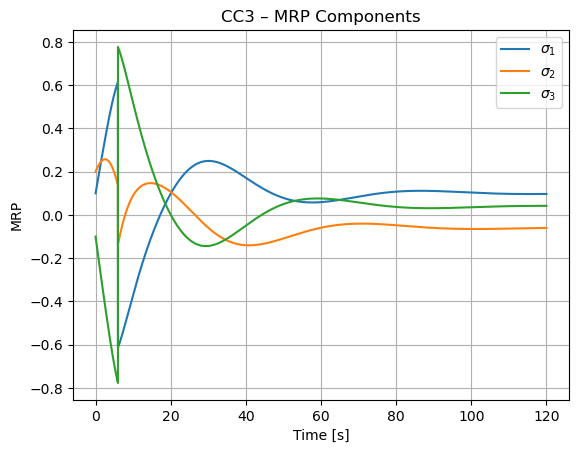

In [28]:
t = cc3_sim_results['t']
x = cc3_sim_results['x']
u = cc3_sim_results['u']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC3 – MRP Components")
plt.legend()
plt.show()

In [29]:
cc3_sim_results["sigma_BR"][-1]

array([ 0.09708434, -0.05996293,  0.04214907])

## CC4

In [30]:
def cc4_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC4 nonlinear attitude tracking controller with integral action.

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - omega_BN_B x omega_RN_B)
              + omega_BN_B x (I*omega_BN_B)
              - (P*Ki)*z
              - modelL_B

    where
        z = K*eta + I*(omega_BR_B - omega_BR0_B)
        eta = integral_sigma_BR

    State
    -----
    state["sigma_BN"], state["omega_BN_B"]

    Reference
    ---------
    ref["sigma_RN"], ref["omega_RN_R"], ref["omega_dot_RN_R"]

    Context
    -------
    ctx["sc"]["I"]               : inertia matrix in B
    ctx["ctl"]["K"], ["P"], ["Ki"]
    ctx["ctl"]["integral_sigma_BR"]
    ctx["ctl"]["omega_BR0_B"]    optional
    ctx["ctl"]["modelL_B"]       optional disturbance model

    Returns
    -------
    u_B : control torque in body frame B
    """

    # --- unpack state ---
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # --- unpack reference ---
    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    # --- unpack context ---
    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    K = float(ctx["ctl"]["K"])
    P = float(ctx["ctl"]["P"])
    Ki = np.asarray(ctx["ctl"].get("Ki", 0.0), dtype=float)
    eta = np.asarray(ctx["ctl"].get("integral_sigma_BR", np.zeros(3)), dtype=float).reshape(3,)
    omega_BR0_B = np.asarray(ctx["ctl"].get("omega_BR0_B", np.zeros(3)), dtype=float).reshape(3,)
    modelL_B = np.asarray(ctx["ctl"].get("modelL_B", np.zeros(3)), dtype=float).reshape(3,)

    # 1) attitude and rate error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    # 2) feedforward term
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    transport = np.cross(omega_BN_B, omega_RN_B)
    ff = I @ (omega_dot_RN_B - transport)

    # 3) integral structure
    dw = omega_BR_B - omega_BR0_B
    z = (K * eta) + (I @ dw)

    # 4) final control law
    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + ff
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - (P * Ki) * z
        - modelL_B
    )

    return u_B

In [31]:
# --- Parameters ---
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
Ki_q2 = 0.005  # (use this for the CC4 run if that's what your controller expects)
Ki_q4 = 0.0    # unused here unless you explicitly switch gains

deltaL_B = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1], dtype=float)
omega0_deg = np.array([3.0, 1.0, -2.0], dtype=float)

eta0 = np.zeros(3)


spacecraft_params = {
    "I": I,
    "L_B": deltaL_B,   # actual plant disturbance
}

controller_params = {
    "K": K,
    "P": P,
    "Ki": Ki_q4,
    "eta0": eta0,   # initialize integral state
    "modelL_B": np.zeros(3),     # controller disturbance model
}

simulation_config = {
    "t0": 0.0,
    "tf": 240.0,
    "dt": 0.01,
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

reference_config = {
    "mode": "tracking",
    "f": 0.05,
}

grading_config = {
    "time_s": 35.0,
    "quantity": "sigma_BR",
}

# --- Run ---
cc4_sim_results = simulate_CC(
    controller=cc4_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)

cc4_sim_results


simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
simulate_CC: simulated up to t = 150 s
simulate_CC: simulated up to t = 180 s
simulate_CC: simulated up to t = 210 s
simulate_CC: simulated up to t = 240 s
CC: norm(sigma_BR) at t=35.000 s = 0.120285269666710


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 2.3998e+02, 2.3999e+02,
        2.4000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.05235988,  0.01745329,
         -0.03490659],
        [ 0.10010299,  0.20004443, -0.10013171,  0.05235544,  0.01740952,
         -0.03484858],
        [ 0.100206  ,  0.20008871, -0.10026331,  0.052351  ,  0.01736571,
         -0.03479063],
        ...,
        [ 0.02265952,  0.22690136,  0.15088721,  0.05057786,  0.00254138,
         -0.03660782],
        [ 0.02273264,  0.2269452 ,  0.15074255,  0.05058197,  0.00251935,
         -0.03661358],
        [ 0.02280577,  0.22698897,  0.15059788,  0.05058607,  0.00249732,
         -0.03661934]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10010299,  0.20004443, -0.10013171],
        [ 0.100206  ,  0.20008871, -0.10026331],
        ...,
        [ 0.02265952,  0.22690136,  0.15088721],
        [ 0.02273264,  0.2269452 ,  0.15074255],
        [ 0.02280577,  0.226

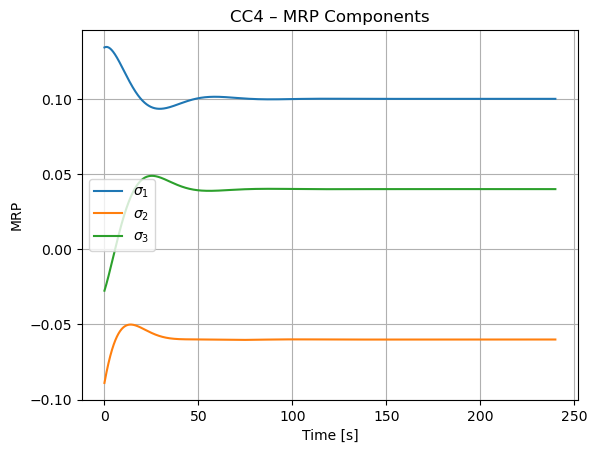

In [32]:
t = cc4_sim_results['t']
x = cc4_sim_results['x']
u = cc4_sim_results['u']

sigma_BR = cc4_sim_results['sigma_BR']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC4 – MRP Components")
plt.legend()
plt.show()

In [33]:
cc4_sim_results['z'][-1]

array([121.10597164, -73.81677785,  45.63126376])

## CC5

In [34]:
def cc5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC5 nonlinear attitude regulator with diagonal rate gains.

    Control law:
        u_B = -K*sigma_BN - P*omega_BN_B
              + omega_BN_B x (I*omega_BN_B)

    This is a pure regulation controller. The reference is assumed
    to be zero attitude and zero rate.

    Context
    -------
    ctx["sc"]["I"]  : inertia matrix in body frame B
    ctx["ctl"]["K"] : attitude gain
    ctx["ctl"]["P"] : rate gain
                      may be scalar, length 3 vector, or 3x3 diagonal matrix

    Returns
    -------
    u_B : control torque in body frame B
    """

    # --- unpack state ---
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # --- unpack context ---
    I = np.asarray(ctx["sc"]["I"], dtype=float).reshape(3, 3)
    K = float(ctx["ctl"]["K"])
    P = np.asarray(ctx["ctl"]["P"], dtype=float)

    # 1) make P act as diagonal gain
    if P.ndim == 0:
        P_mat = np.diag(np.full(3, float(P)))
    elif P.shape == (3,):
        P_mat = np.diag(P)
    elif P.shape == (3, 3):
        P_mat = P
    else:
        raise ValueError("ctx['ctl']['P'] must be scalar, (3,), or (3,3)")

    # 2) control law
    u_B = (
        -K * sigma_BN
        -P_mat @ omega_BN_B
        + np.cross(omega_BN_B, I @ omega_BN_B)
    )

    return u_B

In [35]:
# CC5, Q1
# Given
I = np.diag([100.0, 75.0, 80.0])
K = 5.0


# For MRPs near zero: sigma_dot = 0.25 * omega
# Linearized closed-loop per axis: sigma_ddot + (P_i/I_i)*sigma_dot + (K/(4 I_i))*sigma = 0
# Match to: x_ddot + 2*zeta*wn*x_dot + wn^2*x = 0
# => wn^2 = K/(4 I_i), and 2*zeta*wn = P_i/I_i
# For critical damping (zeta=1): P_i = 2 I_i wn = sqrt(I_i*K)
P = np.sqrt(I * K)

P_diag = np.diag(P)

print(f"GainList, P = {P_diag}")

spacecraft_params = {
    "I": I,
    "L_B": np.zeros(3),   # unperturbed plant
}

controller_params = {
    "K": K,
    "P": P,           
    "modelL_B": np.zeros(3),
}

simulation_config = {
    "t0": 0.0,
    "tf": 120.0,
    "dt": 0.01,
    "sigma0": np.array([0.1, 0.2, -0.1]),
    "omega0_deg": np.array([30.0, 10.0, -20.0]),
}

reference_config = {
    "mode": "regulator",
    "f": 0.0,
}

grading_config = {
    "time_s": 30.0,
    "quantity": "sigma_BN",
}

cc5_sim_results = simulate_CC(
    controller=cc5_controller_u,
    plant=cc_xdot_mrp,
    spacecraft_params=spacecraft_params,
    controller_params=controller_params,
    simulation_config=simulation_config,
    reference_config=reference_config,
    grading_config=grading_config,
)
cc5_sim_results


GainList, P = [22.36067977 19.36491673 20.        ]
simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
CC: norm(sigma_BN) at t=30.000 s = 0.132721515753525


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01028894e-01,  2.00443985e-01, -1.01316601e-01,
          5.22377881e-01,  1.73947730e-01, -3.48131496e-01],
        [ 1.02056089e-01,  2.00885824e-01, -1.02630959e-01,
          5.21159203e-01,  1.73363755e-01, -3.47198652e-01],
        ...,
        [ 1.21536223e-05, -6.85712119e-07, -4.62113963e-06,
         -5.05348191e-06,  3.22275164e-07,  2.15792439e-06],
        [ 1.21409952e-05, -6.84906914e-07, -4.61574795e-06,
         -5.04825879e-06,  3.21900194e-07,  2.15541779e-06],
        [ 1.21283810e-05, -6.84102646e-07, -4.61036253e-06,
         -5.04304104e-06,  3.21525656e-07,  2.15291409e-06]]),
 'sigma_BN': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01],
        [ 1.01028894e-01,  2.00443985e-01, -1.01316601e-01],
        [ 1.02056089

In [36]:
wn = np.sqrt(K / (4.0 * np.diag(I)))   # rad/s
T = 1.0 / wn                       # seconds

T.tolist()  # [T1, T2, T3]


[8.94427190999916, 7.745966692414835, 8.0]

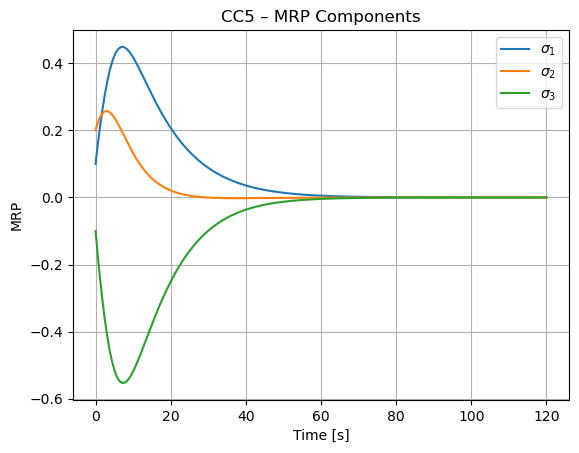

In [37]:
t = cc5_sim_results['t']
x = cc5_sim_results['x']
u = cc5_sim_results['u']

sigma_BN = cc5_sim_results['sigma_BN']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC5 – MRP Components")
plt.legend()
plt.show()